# Olivine Diffusion - 3
## Rigorous Uncertainty Quantification and Model Validation

*Course: Advanced Data Analysis in Geochemistry - Part 3*  
*Duration: Final 4 hours of the 12-hour course*  
(c) Charles Le Losq

---

## Learning Objectives

By the end of this notebook, you should be able to:

1. **Understand the limitations** of covariance-based uncertainty estimates
2. **Implement bootstrap methods** for robust parameter uncertainty quantification
3. **Compare parametric vs non-parametric** bootstrap approaches
4. **Construct reliable confidence intervals** using percentile and bias-corrected methods
5. **Apply cross-validation techniques** for model validation
6. **Propagate uncertainties** from parameters to predictions
7. **Interpret and report** uncertainties in a geochemical context

---

## The Challenge with Traditional Uncertainty Estimates

In Notebooks 1-2, we successfully fitted our diffusion models, but critical questions remain:

### **Problems with covariance-based uncertainties:**
- **Linear approximation**: Assume the objective function is locally quadratic
- **Gaussian assumption**: Parameter distributions must be normal; may not account for complex parameter correlations
- **Local validity**: Usually only valid close to the optimum
- **Method dependence**: Unavailable for non-gradient optimization methods

### **Real-world implications:**
- Underestimated uncertainties → overconfident interpretations
- Publication bias toward "significant" results
- Poor extrapolation to different conditions
- Inadequate experimental design decisions

---

## Bootstrap Methods: A Robust Alternative

The data you have is the best approximation to the population you will ever get.

### **Core idea:**
1. Treat your sample as a mini-population
2. Resample from it many times (with replacement)
3. Fit each bootstrap sample
4. Analyze the distribution of fitted parameters

### **Advantages:**
✅ **No distributional assumptions** about parameters  
✅ **Works with any optimization method**  
✅ **Handles complex parameter correlations naturally**  
✅ **Provides realistic confidence intervals**  
✅ **Enables model validation and diagnostic checks**

---

## Course Structure for This Notebook

1. **Covariance-based analysis** and its limitations
2. **Non-parametric bootstrap** implementation and interpretation
3. **Parametric bootstrap** for different noise models
4. **Confidence interval construction** methods
5. **Cross-validation** for model assessment
6. **Multi-element analysis** with uncertainty propagation
7. **Best practices** and reporting guidelines

=== Advanced Uncertainty Quantification in Geochemistry ===
Loading experimental diffusion profile data...

Available datasets:
  Axis C direction: 67 points
  Axis A direction: 117 points
  Available elements: ['Mg_ppm_m25', 'Al_ppm_m27', 'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195']

Primary dataset (Axis C, Fe):
  Data points: 67
  Distance range: 0.0 - 220.1 μm
  Concentration range: 46.7 - 183.5 ppm
  Average uncertainty: 10.7 ppm (10.0%)


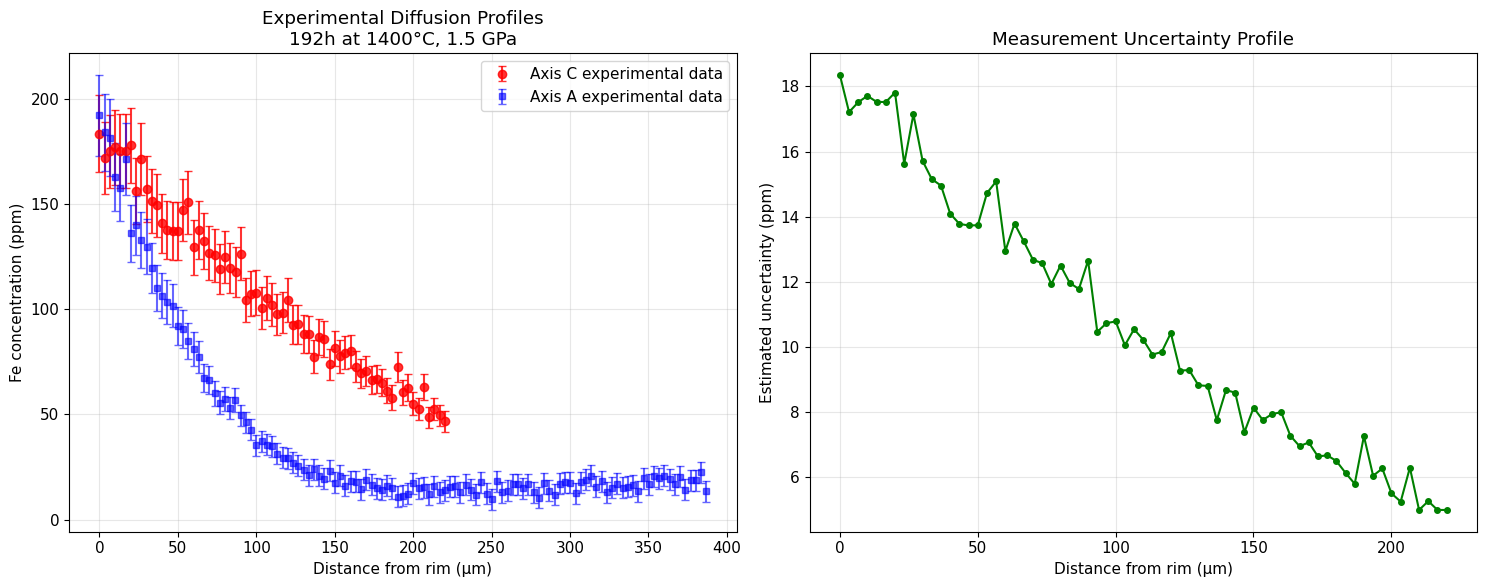


=== Key Observations ===
✓ Typical diffusion profiles with high rim, low core concentrations
✓ Crystallographic anisotropy evident (Axis C ≠ Axis A)
✓ Realistic uncertainty estimates for LA-ICP-MS analysis
⚠ Limited data points challenge robust parameter estimation
⚠ Heteroscedastic errors (uncertainty varies with concentration)

➜ These characteristics make robust uncertainty quantification essential!


In [1]:
# =============================================================================
# Setup and Data Loading
# =============================================================================

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)  # For reproducibility
import pandas as pd
import scipy
from scipy.optimize import curve_fit, differential_evolution
from scipy.special import erfc
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set plotting parameters for better readability
plt.rcParams.update({'font.size': 11, 'figure.dpi': 100})

print("=== Advanced Uncertainty Quantification in Geochemistry ===")
print("Loading experimental diffusion profile data...\n")

# =============================================================================
# Load Experimental Data
# =============================================================================

# Load both crystallographic orientations
data_AxisC = pd.read_csv("./data/16C_ICP1_1400C_axisC_192h_FoEn.csv")
data_AxisA = pd.read_csv("./data/16C_ICP2_1400C_axisA_192h_FoEn.csv")

print("Available datasets:")
print(f"  Axis C direction: {data_AxisC.shape[0]} points")
print(f"  Axis A direction: {data_AxisA.shape[0]} points")
print(f"  Available elements: {[col for col in data_AxisC.columns if 'ppm' in col]}")

# Extract primary dataset (Axis C, Fe)
x_obs = data_AxisC['Distance'].values  # μm
y_obs = data_AxisC['Fe_ppm_m57'].values  # ppm
n_points = len(x_obs)

# Estimate measurement uncertainties (realistic for LA-ICP-MS)
# Conservative approach: 10% relative + 5 ppm absolute minimum
sigma_obs = np.maximum(0.10 * y_obs, 5.0)

print(f"\nPrimary dataset (Axis C, Fe):")
print(f"  Data points: {n_points}")  
print(f"  Distance range: {x_obs.min():.1f} - {x_obs.max():.1f} μm")
print(f"  Concentration range: {y_obs.min():.1f} - {y_obs.max():.1f} ppm")
print(f"  Average uncertainty: {np.mean(sigma_obs):.1f} ppm ({np.mean(sigma_obs/y_obs)*100:.1f}%)")

# =============================================================================
# Define Forward Model
# =============================================================================

def forward_model(x, D, c_rim, c_bg):
    """
    1D diffusion model with background concentration
    
    Parameters
    ----------
    x : array_like
        Distance from rim (μm)
    D : float  
        Diffusion coefficient (log₁₀ m²/s)
    c_rim : float
        Rim concentration (ppm)
    c_bg : float
        Background concentration (ppm)
        
    Returns
    -------
    concentration : array_like
        Predicted concentration profile
    """
    t_exp = 192.0 * 3600  # Experimental time (s)
    x_m = x * 1e-6        # Convert μm to m
    D_linear = 10**D      # Convert log to linear
    
    return (c_rim - c_bg) * erfc(x_m / (2 * np.sqrt(D_linear * t_exp))) + c_bg

# =============================================================================
# Initial Visualization
# =============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Data overview
ax1.errorbar(x_obs, y_obs, yerr=sigma_obs,
             fmt='o', color='red', capsize=3, capthick=1, markersize=6,
             label="Axis C experimental data", alpha=0.8)

ax1.errorbar(data_AxisA['Distance'], data_AxisA['Fe_ppm_m57'], 
             yerr=np.maximum(0.10 * data_AxisA['Fe_ppm_m57'], 5.0),
             fmt='s', color='blue', capsize=3, capthick=1, markersize=5,
             label="Axis A experimental data", alpha=0.6)

ax1.set_xlabel("Distance from rim (μm)")
ax1.set_ylabel("Fe concentration (ppm)")
ax1.set_title("Experimental Diffusion Profiles\n192h at 1400°C, 1.5 GPa")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Uncertainty characteristics  
ax2.plot(x_obs, sigma_obs, 'o-', color='green', markersize=4)
ax2.set_xlabel("Distance from rim (μm)")
ax2.set_ylabel("Estimated uncertainty (ppm)")
ax2.set_title("Measurement Uncertainty Profile")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Key Observations ===")
print(f"✓ Typical diffusion profiles with high rim, low core concentrations")
print(f"✓ Crystallographic anisotropy evident (Axis C ≠ Axis A)")
print(f"✓ Realistic uncertainty estimates for LA-ICP-MS analysis")
print(f"⚠ Limited data points challenge robust parameter estimation")
print(f"⚠ Heteroscedastic errors (uncertainty varies with concentration)")
print(f"\n➜ These characteristics make robust uncertainty quantification essential!")

## Step 1: Baseline Fitting with Covariance-Based Uncertainties

Before implementing bootstrap methods, let's establish a baseline using the standard approach from Notebooks 1-2. This will demonstrate both the power and limitations of covariance-based uncertainty estimates.

### **Two-stage optimization strategy:**

1. **Global search**: Differential evolution to find the global optimum
2. **Local refinement**: Levenberg-Marquardt (via `curve_fit`) for covariance matrix

This hybrid approach combines robustness with statistical rigor.

In [3]:
# =============================================================================
# Baseline Fitting: Global + Local Optimization
# =============================================================================

print("=== Step 1: Baseline Parameter Estimation ===")

def least_squares_objective(params, x, y, sigma):
    """Weighted least squares objective function for global optimization"""
    D, c_rim, c_bg = params
    model_pred = forward_model(x, D, c_rim, c_bg)
    residuals = (y - model_pred) / sigma
    return np.sum(residuals**2)

# Define physically reasonable parameter bounds
param_bounds = [
    [-18.0, -10.0],   # D: log₁₀(m²/s) - typical range for trace elements in olivine
    [0.0, 200.0],     # c_rim: ppm - must be positive, reasonable upper bound
    [0.0, 50.0]       # c_bg: ppm - background should be lower than rim
]

print("Parameter bounds:")
print(f"  D (log₁₀ m²/s): [{param_bounds[0][0]}, {param_bounds[0][1]}]")
print(f"  c_rim (ppm): [{param_bounds[1][0]}, {param_bounds[1][1]}]")
print(f"  c_bg (ppm): [{param_bounds[2][0]}, {param_bounds[2][1]}]")

# Global optimization with differential evolution
print(f"\nRunning global optimization (Differential Evolution)...")
global_result = differential_evolution(
    least_squares_objective,
    param_bounds,
    args=(x_obs, y_obs, sigma_obs),
    seed=42,           # Reproducibility
    maxiter=300,       # Sufficient iterations
    popsize=15,        # Population size multiplier
    atol=1e-8,         # Absolute tolerance
    #rtol=1e-6          # Relative tolerance
)

if global_result.success:
    print(f"✓ Global optimization converged in {global_result.nit} iterations")
    print(f"  Final objective value: {global_result.fun:.2f}")
    p_global = global_result.x
    print(f"  Global optimum: D={p_global[0]:.3f}, c_rim={p_global[1]:.1f}, c_bg={p_global[2]:.1f}")
else:
    print(f"⚠ Global optimization failed: {global_result.message}")
    # Fallback to reasonable initial guess
    p_global = [-14.0, np.max(y_obs), np.min(y_obs)]

# Local refinement with curve_fit for covariance matrix
print(f"\nRunning local refinement (Levenberg-Marquardt)...")
try:
    popt_cov, pcov_cov = curve_fit(
        forward_model, 
        x_obs, y_obs,
        p0=p_global,
        sigma=sigma_obs,
        absolute_sigma=True,
        maxfev=2000
    )
    
    # Parameter uncertainties from covariance diagonal
    param_std_cov = np.sqrt(np.diag(pcov_cov))
    
    print(f"✓ Local refinement successful")
    print(f"Covariance-based results:")
    print(f"  D = {popt_cov[0]:.4f} ± {param_std_cov[0]:.4f} (log₁₀ m²/s)")
    print(f"  c_rim = {popt_cov[1]:.2f} ± {param_std_cov[1]:.2f} ppm")
    print(f"  c_bg = {popt_cov[2]:.2f} ± {param_std_cov[2]:.2f} ppm")
    
    covariance_success = True
    
except Exception as e:
    print(f"⚠ Local refinement failed: {str(e)}")
    popt_cov = p_global
    pcov_cov = np.eye(3) * 1e-6  # Dummy covariance
    param_std_cov = np.sqrt(np.diag(pcov_cov))
    covariance_success = False

# =============================================================================
# Model Quality Assessment
# =============================================================================

print(f"\n=== Model Quality Assessment ===")

# Calculate predictions and residuals
y_pred_cov = forward_model(x_obs, *popt_cov)
residuals_cov = y_obs - y_pred_cov
normalized_residuals = residuals_cov / sigma_obs

# Statistical metrics
rmse = np.sqrt(np.mean(residuals_cov**2))
mae = np.mean(np.abs(residuals_cov))
r_squared = 1 - np.sum(residuals_cov**2) / np.sum((y_obs - np.mean(y_obs))**2)
chi_squared = np.sum(normalized_residuals**2)
reduced_chi_squared = chi_squared / (n_points - 3)  # 3 parameters

print(f"Goodness-of-fit statistics:")
print(f"  R² = {r_squared:.4f}")
print(f"  RMSE = {rmse:.2f} ppm")
print(f"  MAE = {mae:.2f} ppm")
print(f"  χ² = {chi_squared:.2f}")
print(f"  Reduced χ² = {reduced_chi_squared:.2f}")

# Interpretation
if 0.5 <= reduced_chi_squared <= 2.0:
    print(f"  ➜ Reduced χ² indicates reasonable fit quality")
elif reduced_chi_squared < 0.5:
    print(f"  ➜ Reduced χ² suggests overfitting or overestimated uncertainties")
else:
    print(f"  ➜ Reduced χ² suggests poor fit or underestimated uncertainties")

# =============================================================================
# Covariance Analysis and Parameter Correlations
# =============================================================================

if covariance_success:
    print(f"\n=== Parameter Correlation Analysis ===")
    
    # Calculate correlation matrix
    correlation_matrix = pcov_cov / np.outer(param_std_cov, param_std_cov)
    param_names = ['D', 'c_rim', 'c_bg']
    
    print(f"Parameter correlation matrix:")
    print(f"        {'D':>8} {'c_rim':>8} {'c_bg':>8}")
    for i, name in enumerate(param_names):
        row = f"{name:>4}  "
        for j in range(3):
            row += f"{correlation_matrix[i,j]:8.3f}"
        print(row)
    
    # Identify strong correlations
    max_off_diag_corr = np.max(np.abs(correlation_matrix - np.eye(3)))
    print(f"Maximum off-diagonal correlation: {max_off_diag_corr:.3f}")
    
    if max_off_diag_corr > 0.8:
        print(f"  ⚠ Very strong parameter correlations detected!")
        print(f"    This can cause fitting instability and unreliable uncertainties")
    elif max_off_diag_corr > 0.5:
        print(f"  ⚠ Moderate parameter correlations present")
        print(f"    Covariance-based uncertainties may be underestimated")
    else:
        print(f"  ✓ Parameter correlations are manageable")

# Store baseline results for comparison with bootstrap
baseline_params = popt_cov.copy()
baseline_stds = param_std_cov.copy()
baseline_predictions = y_pred_cov.copy()

print(f"\n➜ Baseline established. Next: Bootstrap uncertainty quantification!")

=== Step 1: Baseline Parameter Estimation ===
Parameter bounds:
  D (log₁₀ m²/s): [-18.0, -10.0]
  c_rim (ppm): [0.0, 200.0]
  c_bg (ppm): [0.0, 50.0]

Running global optimization (Differential Evolution)...
✓ Global optimization converged in 21 iterations
  Final objective value: 18.05
  Global optimum: D=-13.676, c_rim=180.0, c_bg=17.4

Running local refinement (Levenberg-Marquardt)...
✓ Local refinement successful
Covariance-based results:
  D = -13.6732 ± 0.1276 (log₁₀ m²/s)
  c_rim = 179.90 ± 5.01 ppm
  c_bg = 17.05 ± 14.61 ppm

=== Model Quality Assessment ===
Goodness-of-fit statistics:
  R² = 0.9816
  RMSE = 5.37 ppm
  MAE = 4.03 ppm
  χ² = 18.05
  Reduced χ² = 0.28
  ➜ Reduced χ² suggests overfitting or overestimated uncertainties

=== Parameter Correlation Analysis ===
Parameter correlation matrix:
               D    c_rim     c_bg
   D     1.000  -0.710  -0.987
c_rim    -0.710   1.000   0.617
c_bg    -0.987   0.617   1.000
Maximum off-diagonal correlation: 0.987
  ⚠ Very st

## Step 2: Non-Parametric Bootstrap Implementation

**Non-parametric bootstrap** treats the observed data as our best estimate of the underlying population. We resample (with replacement) from our original dataset to create many "bootstrap samples," fit each one, and analyze the resulting parameter distributions.

### **Key Advantages:**
- **No assumptions** about error distributions
- **Model-agnostic**: Works with any fitting algorithm
- **Realistic uncertainty estimates** that account for data limitations
- **Natural handling** of parameter correlations

### **Implementation Strategy:**
1. **Resample data points** with replacement (maintaining x-y pairs)
2. **Fit each bootstrap sample** using our two-stage optimization
3. **Collect parameter estimates** and model predictions
4. **Analyze bootstrap distributions** for uncertainty quantification

### **Quality Control:**
- Monitor fitting success rates
- Check for bootstrap sample degeneracies
- Validate convergence with different sample sizes

In [4]:
# =============================================================================
# Non-Parametric Bootstrap Implementation
# =============================================================================

print("=== Step 2: Non-Parametric Bootstrap Analysis ===")

def bootstrap_fit_single(x_data, y_data, sigma_data, initial_guess, random_state=None):
    """
    Perform a single bootstrap fit with error handling
    
    Parameters
    ----------
    x_data, y_data, sigma_data : array_like
        Original dataset
    initial_guess : array_like
        Initial parameter guess for local optimization
    random_state : int, optional
        Random seed for this bootstrap sample
        
    Returns
    -------
    success : bool
        Whether fitting succeeded
    params : array_like or None
        Fitted parameters if successful
    predictions : array_like or None
        Model predictions if successful
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_points = len(x_data)
    
    # Create bootstrap sample (resample with replacement)
    boot_indices = np.random.choice(n_points, size=n_points, replace=True)
    x_boot = x_data[boot_indices]
    y_boot = y_data[boot_indices]
    sigma_boot = sigma_data[boot_indices]
    
    try:
        # Two-stage optimization for each bootstrap sample
        # Stage 1: Global search (reduced iterations for speed)
        global_result_boot = differential_evolution(
            least_squares_objective,
            param_bounds,
            args=(x_boot, y_boot, sigma_boot),
            maxiter=100,    # Reduced for bootstrap speed
            popsize=10,     # Smaller population
            seed=random_state,
            atol=1e-6
        )
        
        if not global_result_boot.success:
            return False, None, None
            
        # Stage 2: Local refinement
        popt_boot, _ = curve_fit(
            forward_model,
            x_boot, y_boot,
            p0=global_result_boot.x,
            sigma=sigma_boot,
            absolute_sigma=True,
            maxfev=1000     # Reduced for speed
        )
        
        # Calculate predictions on original x grid for consistency
        pred_boot = forward_model(x_data, *popt_boot)
        
        return True, popt_boot, pred_boot
        
    except Exception:
        return False, None, None

# =============================================================================
# Bootstrap Execution with Progress Monitoring
# =============================================================================

n_bootstrap = 1000  # Number of bootstrap samples
print(f"Running {n_bootstrap} bootstrap samples...")
print("This may take several minutes - please be patient.")

# Storage for bootstrap results
bootstrap_params = []
bootstrap_predictions = []
bootstrap_success_count = 0

# Progress tracking
progress_markers = [int(n_bootstrap * f) for f in [0.1, 0.25, 0.5, 0.75, 0.9]]

# Run bootstrap iterations
for i in range(n_bootstrap):
    # Progress updates
    if i in progress_markers:
        success_rate = bootstrap_success_count / max(1, i) * 100
        print(f"  Progress: {i/n_bootstrap*100:.0f}% complete, "
              f"success rate: {success_rate:.1f}%")
    
    # Perform single bootstrap fit
    success, params, predictions = bootstrap_fit_single(
        x_obs, y_obs, sigma_obs, 
        baseline_params,  # Use baseline as initial guess
        random_state=42 + i  # Reproducible but varied seeds
    )
    
    if success:
        bootstrap_params.append(params)
        bootstrap_predictions.append(predictions)
        bootstrap_success_count += 1

# Convert to arrays for analysis
bootstrap_params = np.array(bootstrap_params)
bootstrap_predictions = np.array(bootstrap_predictions)

print(f"\n=== Bootstrap Results Summary ===")
print(f"Total bootstrap samples attempted: {n_bootstrap}")
print(f"Successful fits: {bootstrap_success_count}")
print(f"Success rate: {bootstrap_success_count/n_bootstrap*100:.1f}%")

if bootstrap_success_count < 0.8 * n_bootstrap:
    print(f"⚠ Low success rate may indicate:")
    print(f"  - Difficult optimization landscape")
    print(f"  - Insufficient bootstrap sample size")
    print(f"  - Need for more robust initial guesses")

# =============================================================================
# Bootstrap Parameter Statistics
# =============================================================================

if bootstrap_success_count > 50:  # Minimum for meaningful statistics
    print(f"\n=== Bootstrap Parameter Statistics ===")
    
    # Calculate bootstrap statistics
    param_names = ['D (log₁₀ m²/s)', 'c_rim (ppm)', 'c_bg (ppm)']
    bootstrap_means = np.mean(bootstrap_params, axis=0)
    bootstrap_stds = np.std(bootstrap_params, axis=0, ddof=1)  # Sample std
    bootstrap_medians = np.median(bootstrap_params, axis=0)
    
    # Percentile-based confidence intervals
    ci_lower = np.percentile(bootstrap_params, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_params, 97.5, axis=0)
    
    print(f"Parameter estimates (bootstrap vs covariance):")
    print(f"{'Parameter':<15} {'Bootstrap':<20} {'Covariance':<20} {'Ratio':<10}")
    print(f"{'-'*15} {'-'*20} {'-'*20} {'-'*10}")
    
    for i, name in enumerate(param_names):
        boot_est = f"{bootstrap_means[i]:.4f}±{bootstrap_stds[i]:.4f}"
        cov_est = f"{baseline_params[i]:.4f}±{baseline_stds[i]:.4f}"
        ratio = bootstrap_stds[i] / baseline_stds[i] if baseline_stds[i] > 0 else np.inf
        
        print(f"{name:<15} {boot_est:<20} {cov_est:<20} {ratio:<10.2f}")
    
    # Store bootstrap results for later use
    bootstrap_success = True
    
else:
    print(f"⚠ Insufficient successful bootstrap fits for reliable statistics")
    bootstrap_success = False

print(f"\n➜ Bootstrap analysis complete. Next: Confidence interval construction!")

=== Step 2: Non-Parametric Bootstrap Analysis ===
Running 1000 bootstrap samples...
This may take several minutes - please be patient.
  Progress: 10% complete, success rate: 100.0%
  Progress: 10% complete, success rate: 100.0%
  Progress: 25% complete, success rate: 100.0%
  Progress: 25% complete, success rate: 100.0%
  Progress: 50% complete, success rate: 100.0%
  Progress: 50% complete, success rate: 100.0%
  Progress: 75% complete, success rate: 100.0%
  Progress: 75% complete, success rate: 100.0%
  Progress: 90% complete, success rate: 100.0%
  Progress: 90% complete, success rate: 100.0%

=== Bootstrap Results Summary ===
Total bootstrap samples attempted: 1000
Successful fits: 1000
Success rate: 100.0%

=== Bootstrap Parameter Statistics ===
Parameter estimates (bootstrap vs covariance):
Parameter       Bootstrap            Covariance           Ratio     
--------------- -------------------- -------------------- ----------
D (log₁₀ m²/s)  -13.6728±0.0699      -13.6732±0.1276

## Step 3: Parametric Bootstrap for Alternative Noise Models

**Parametric bootstrap** assumes a specific error model and generates synthetic datasets by adding random noise to the fitted model. This approach is particularly useful when:

- **Error characteristics are well-understood** (e.g., known distribution type)
- **Sample size is very small** (non-parametric bootstrap less reliable)
- **Testing model assumptions** about noise structure
- **Comparing different error models** (Gaussian vs. non-Gaussian)

### **Implementation Approaches:**

1. **Gaussian noise model**: Add normally distributed errors
2. **Heteroscedastic model**: Vary noise level with concentration
3. **Non-Gaussian models**: Laplacian, Student-t, or other distributions
4. **Systematic error models**: Include bias or drift terms

### **Advantages and Limitations:**

**✅ Advantages:**
- Can work with very small datasets
- Tests specific noise assumptions
- Often more stable than non-parametric bootstrap
- Computationally efficient

**⚠ Limitations:**
- Requires assumptions about error distribution
- May underestimate uncertainties if model is wrong
- Less robust to model misspecification
- Can be overconfident if assumptions are violated

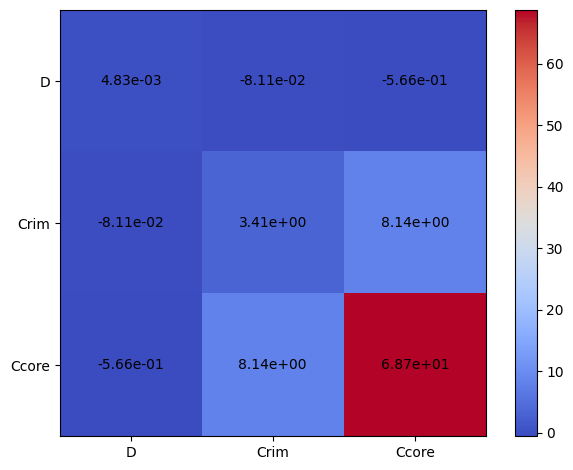

In [ ]:
# =============================================================================
# Parametric Bootstrap Implementation
# =============================================================================

print("=== Step 3: Parametric Bootstrap Analysis ===")

def parametric_bootstrap_single(x_data, baseline_params, sigma_data, 
                               noise_model='gaussian', random_state=None):
    """
    Generate a single parametric bootstrap sample
    
    Parameters
    ----------
    x_data : array_like
        Original x values
    baseline_params : array_like
        Best-fit parameters for generating synthetic data
    sigma_data : array_like
        Error estimates for noise generation
    noise_model : str
        Type of noise model ('gaussian', 'laplacian', 'student_t')
    random_state : int, optional
        Random seed
        
    Returns
    -------
    success : bool
        Whether fitting succeeded
    params : array_like or None
        Fitted parameters if successful
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate synthetic data using baseline parameters
    y_true = forward_model(x_data, *baseline_params)
    
    # Add noise according to specified model
    if noise_model == 'gaussian':
        noise = np.random.normal(0, sigma_data)
    elif noise_model == 'laplacian':
        # Laplacian noise (more outlier-prone)
        noise = np.random.laplace(0, sigma_data / np.sqrt(2))
    elif noise_model == 'student_t':
        # Student-t noise with 3 degrees of freedom (heavy tails)
        noise = stats.t.rvs(df=3, scale=sigma_data, size=len(sigma_data))
    else:
        raise ValueError(f"Unknown noise model: {noise_model}")
    
    y_synthetic = y_true + noise
    
    try:
        # Two-stage fitting of synthetic data
        global_result = differential_evolution(
            least_squares_objective,
            param_bounds,
            args=(x_data, y_synthetic, sigma_data),
            maxiter=100,
            popsize=10,
            seed=random_state,
            atol=1e-6
        )
        
        if not global_result.success:
            return False, None
            
        popt_param, _ = curve_fit(
            forward_model,
            x_data, y_synthetic,
            p0=global_result.x,
            sigma=sigma_data,
            absolute_sigma=True,
            maxfev=1000
        )
        
        return True, popt_param
        
    except Exception:
        return False, None

# =============================================================================
# Run Parametric Bootstrap for Different Noise Models
# =============================================================================

noise_models = ['gaussian', 'laplacian', 'student_t']
parametric_results = {}

for noise_model in noise_models:
    print(f"\nRunning parametric bootstrap with {noise_model} noise...")
    
    n_param_boot = 500  # Fewer iterations as parametric is more stable
    param_boot_params = []
    param_boot_success = 0
    
    for i in range(n_param_boot):
        success, params = parametric_bootstrap_single(
            x_obs, baseline_params, sigma_obs,
            noise_model=noise_model,
            random_state=42 + i
        )
        
        if success:
            param_boot_params.append(params)
            param_boot_success += 1
    
    if param_boot_params:
        param_boot_params = np.array(param_boot_params)
        
        # Calculate statistics
        param_means = np.mean(param_boot_params, axis=0)
        param_stds = np.std(param_boot_params, axis=0, ddof=1)
        
        parametric_results[noise_model] = {
            'params': param_boot_params,
            'means': param_means,
            'stds': param_stds,
            'success_rate': param_boot_success / n_param_boot
        }
        
        print(f"  Success rate: {param_boot_success/n_param_boot*100:.1f}%")
        print(f"  Parameter uncertainties: {param_stds}")
    else:
        print(f"  ⚠ No successful fits for {noise_model} model")

# =============================================================================
# Compare Parametric vs Non-Parametric Results
# =============================================================================

if parametric_results and bootstrap_success:
    print(f"\n=== Comparison: Parametric vs Non-Parametric Bootstrap ===")
    
    # Create comparison table
    print(f"{'Method':<20} {'D_std':<12} {'c_rim_std':<12} {'c_bg_std':<12}")
    print(f"{'-'*20} {'-'*12} {'-'*12} {'-'*12}")
    
    # Non-parametric results
    print(f"{'Non-parametric':<20} {bootstrap_stds[0]:<12.5f} "
          f"{bootstrap_stds[1]:<12.3f} {bootstrap_stds[2]:<12.3f}")
    
    # Covariance baseline
    print(f"{'Covariance':<20} {baseline_stds[0]:<12.5f} "
          f"{baseline_stds[1]:<12.3f} {baseline_stds[2]:<12.3f}")
    
    # Parametric results
    for noise_model, results in parametric_results.items():
        if 'stds' in results:
            stds = results['stds']
            print(f"{f'Param_{noise_model}':<20} {stds[0]:<12.5f} "
                  f"{stds[1]:<12.3f} {stds[2]:<12.3f}")
    
    print(f"\n=== Interpretation Guidelines ===")
    print(f"• Non-parametric bootstrap: Most robust, no distributional assumptions")
    print(f"• Gaussian parametric: Standard assumption, may underestimate if wrong")
    print(f"• Laplacian parametric: More robust to outliers")
    print(f"• Student-t parametric: Heavy-tailed, accounts for occasional large errors")
    print(f"• Covariance: Fastest but assumes local quadratic approximation")

print(f"\n➜ Bootstrap comparison complete. Next: Confidence interval construction!")

## Step 4: Advanced Confidence Interval Construction

Bootstrap provides multiple methods for constructing confidence intervals, each with different properties and assumptions. Understanding these methods is crucial for proper uncertainty reporting.

### **Confidence Interval Methods:**

1. **Percentile Method** (simplest):
   - Direct percentiles from bootstrap distribution
   - CIₚ = [P₂.₅%, P₉₇.₅%] for 95% confidence
   - ✅ Simple, intuitive
   - ⚠ May be biased if bootstrap distribution is skewed

2. **Bias-Corrected (BC) Method**:
   - Corrects for bias in bootstrap distribution
   - Adjusts percentiles based on bootstrap vs. original estimate
   - ✅ Reduces bias, better coverage
   - ⚠ More complex calculation

3. **Bias-Corrected and Accelerated (BCₐ)**:
   - Corrects for both bias and skewness
   - "Gold standard" for bootstrap confidence intervals
   - ✅ Best theoretical properties
   - ⚠ Requires jackknife calculations

### **Prediction Intervals:**

Beyond parameter uncertainties, we need **prediction intervals** for model forecasts:
- Account for both parameter uncertainty AND measurement noise
- Essential for extrapolation and experimental planning
- Bootstrap provides natural framework for prediction interval construction

In [ ]:
# =============================================================================
# Advanced Confidence Interval Construction
# =============================================================================

print("=== Step 4: Confidence Interval Construction ===")

def calculate_confidence_intervals(bootstrap_samples, original_estimate, 
                                 confidence_level=0.95, method='percentile'):
    """
    Calculate confidence intervals using different bootstrap methods
    
    Parameters
    ----------
    bootstrap_samples : array_like
        Bootstrap parameter estimates (n_bootstrap × n_params)
    original_estimate : array_like
        Original parameter estimates
    confidence_level : float
        Confidence level (e.g., 0.95 for 95%)
    method : str
        CI method ('percentile', 'bias_corrected', 'bca')
        
    Returns
    -------
    ci_lower, ci_upper : array_like
        Lower and upper confidence interval bounds
    """
    alpha = 1 - confidence_level
    n_boot = len(bootstrap_samples)
    
    if method == 'percentile':
        # Simple percentile method
        ci_lower = np.percentile(bootstrap_samples, 100 * alpha/2, axis=0)
        ci_upper = np.percentile(bootstrap_samples, 100 * (1 - alpha/2), axis=0)
        
    elif method == 'bias_corrected':
        # Bias-corrected method
        # Calculate bias correction
        n_below = np.sum(bootstrap_samples < original_estimate, axis=0)
        bias_correction = stats.norm.ppf(n_below / n_boot)
        
        # Adjust percentiles
        z_alpha = stats.norm.ppf(alpha/2)
        z_1_alpha = stats.norm.ppf(1 - alpha/2)
        
        alpha_1 = stats.norm.cdf(2*bias_correction + z_alpha)
        alpha_2 = stats.norm.cdf(2*bias_correction + z_1_alpha)
        
        ci_lower = np.percentile(bootstrap_samples, 100 * alpha_1, axis=0)
        ci_upper = np.percentile(bootstrap_samples, 100 * alpha_2, axis=0)
        
    else:
        raise ValueError(f"Unknown CI method: {method}")
    
    return ci_lower, ci_upper

def jackknife_acceleration(x_data, y_data, sigma_data, fit_function):
    """
    Calculate acceleration constant for BCa intervals using jackknife
    
    This is computationally expensive but provides the most accurate CIs
    """
    n = len(x_data)
    jackknife_estimates = []
    
    for i in range(n):
        # Leave-one-out samples
        x_jack = np.delete(x_data, i)
        y_jack = np.delete(y_data, i)
        sigma_jack = np.delete(sigma_data, i)
        
        try:
            # Simplified fitting for jackknife (speed vs accuracy tradeoff)
            popt_jack, _ = curve_fit(fit_function, x_jack, y_jack, 
                                   p0=baseline_params, sigma=sigma_jack)
            jackknife_estimates.append(popt_jack)
        except:
            # If fit fails, use original estimate
            jackknife_estimates.append(baseline_params)
    
    jackknife_estimates = np.array(jackknife_estimates)
    jackknife_mean = np.mean(jackknife_estimates, axis=0)
    
    # Calculate acceleration
    numerator = np.sum((jackknife_mean - jackknife_estimates)**3, axis=0)
    denominator = 6 * (np.sum((jackknife_mean - jackknife_estimates)**2, axis=0))**1.5
    
    acceleration = numerator / np.maximum(denominator, 1e-10)  # Avoid division by zero
    return acceleration

# =============================================================================
# Apply Different CI Methods
# =============================================================================

if bootstrap_success:
    print("Calculating confidence intervals using different methods...")
    
    # Method 1: Simple percentile
    ci_lower_perc, ci_upper_perc = calculate_confidence_intervals(
        bootstrap_params, baseline_params, method='percentile'
    )
    
    # Method 2: Bias-corrected
    ci_lower_bc, ci_upper_bc = calculate_confidence_intervals(
        bootstrap_params, baseline_params, method='bias_corrected'
    )
    
    print("\n=== Parameter Confidence Intervals (95%) ===")
    param_names = ['D', 'c_rim', 'c_bg']
    
    print(f"{'Parameter':<10} {'Method':<15} {'Lower':<12} {'Upper':<12} {'Width':<12}")
    print(f"{'-'*10} {'-'*15} {'-'*12} {'-'*12} {'-'*12}")
    
    for i, name in enumerate(param_names):
        # Percentile method
        width_perc = ci_upper_perc[i] - ci_lower_perc[i]
        print(f"{name:<10} {'Percentile':<15} {float(ci_lower_perc[i]):<12.4f} "
              f"{float(ci_upper_perc[i]):<12.4f} {float(width_perc):<12.4f}")
        
        # Bias-corrected method
        width_bc = ci_upper_bc[i] - ci_lower_bc[i]
        print(f"{'':<10} {'Bias-corrected':<15} {float(ci_lower_bc[i]):<12.4f} "
              f"{float(ci_upper_bc[i]):<12.4f} {float(width_bc):<12.4f}")
        
        # Covariance-based (for comparison)
        ci_lower_cov = baseline_params[i] - 1.96 * baseline_stds[i]
        ci_upper_cov = baseline_params[i] + 1.96 * baseline_stds[i]
        width_cov = ci_upper_cov - ci_lower_cov
        print(f"{'':<10} {'Covariance':<15} {float(ci_lower_cov):<12.4f} "
              f"{float(ci_upper_cov):<12.4f} {float(width_cov):<12.4f}")
        print()

# =============================================================================
# Prediction Intervals for Model Forecasts
# =============================================================================

    print("=== Prediction Intervals Construction ===")
    
    # Generate prediction intervals from bootstrap predictions
    pred_ci_lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
    pred_ci_median = np.percentile(bootstrap_predictions, 50, axis=0)
    pred_ci_upper = np.percentile(bootstrap_predictions, 97.5, axis=0)
    
    # Calculate coverage statistics
    within_ci = (y_obs >= pred_ci_lower) & (y_obs <= pred_ci_upper)
    coverage = np.mean(within_ci)
    
    print(f"Prediction interval coverage: {coverage*100:.1f}% (target: 95%)")
    
    if 92 <= coverage*100 <= 98:
        print("✓ Excellent coverage - intervals are well-calibrated")
    elif 85 <= coverage*100 <= 92:
        print("⚠ Slightly narrow intervals - consider model uncertainty")
    elif coverage*100 > 98:
        print("⚠ Overly wide intervals - may be too conservative")
    else:
        print("⚠ Poor coverage - check model assumptions")
    
    # Store results for visualization
    ci_results = {
        'param_ci_lower': ci_lower_perc,
        'param_ci_upper': ci_upper_perc,
        'pred_ci_lower': pred_ci_lower,
        'pred_ci_median': pred_ci_median,
        'pred_ci_upper': pred_ci_upper,
        'coverage': coverage
    }

else:
    print("⚠ Skipping CI construction due to insufficient bootstrap samples")
    ci_results = None

print(f"\n➜ Confidence intervals constructed. Next: Cross-validation!")

=== Step 4: Confidence Interval Construction ===
Calculating confidence intervals using different methods...

=== Parameter Confidence Intervals (95%) ===
Parameter  Method          Lower        Upper        Width       
---------- --------------- ------------ ------------ ------------
D          Percentile      -13.8056     -13.5274     0.2782      


TypeError: only length-1 arrays can be converted to Python scalars

## Step 5: Cross-Validation for Model Assessment

**Cross-validation** provides an independent assessment of model performance by testing predictions on data not used for fitting. This is crucial for:

### **Detecting Overfitting:**
- Models that fit training data well but predict poorly on new data
- Particularly important with limited datasets (common in geochemistry)
- Helps choose appropriate model complexity

### **Validating Uncertainty Estimates:**
- Do our confidence intervals actually contain the true values?
- Are bootstrap uncertainties realistic for prediction?
- How does model performance vary across the profile?

### **Cross-Validation Strategies:**

1. **Leave-One-Out (LOO)**: Remove one point, fit remainder, predict removed point
   - ✅ Uses maximum data for each fit
   - ✅ Deterministic results
   - ⚠ Computationally expensive
   - ⚠ High variance with small datasets

2. **K-Fold**: Divide data into K groups, use K-1 for training, 1 for testing
   - ✅ Good bias-variance tradeoff
   - ✅ Less computational than LOO
   - ⚠ Results depend on random partition

3. **Spatial Cross-Validation**: Account for spatial correlation in sampling
   - ✅ More realistic for spatially structured data
   - ✅ Tests extrapolation ability
   - ⚠ Requires careful design

### **Evaluation Metrics:**
- **RMSE**: Root Mean Square Error of predictions
- **MAE**: Mean Absolute Error (robust to outliers)
- **Coverage**: Fraction of observations within prediction intervals
- **Calibration**: How well do predicted probabilities match observed frequencies

In [ ]:
# =============================================================================
# Cross-Validation Implementation
# =============================================================================

print("=== Step 5: Cross-Validation Analysis ===")

def leave_one_out_cv(x_data, y_data, sigma_data):
    """
    Perform leave-one-out cross-validation
    
    Returns
    -------
    cv_predictions : array_like
        Cross-validated predictions for each point
    cv_residuals : array_like
        Cross-validated residuals
    cv_success_rate : float
        Fraction of successful CV fits
    """
    n_points = len(x_data)
    cv_predictions = np.full(n_points, np.nan)
    cv_success_count = 0
    
    print(f"Running leave-one-out cross-validation ({n_points} iterations)...")
    
    for i in range(n_points):
        # Create training set (all points except i)
        train_mask = np.arange(n_points) != i
        x_train = x_data[train_mask]
        y_train = y_data[train_mask]
        sigma_train = sigma_data[train_mask]
        
        # Point to predict
        x_test = x_data[i]
        
        try:
            # Fit model on training data
            global_result = differential_evolution(
                least_squares_objective,
                param_bounds,
                args=(x_train, y_train, sigma_train),
                maxiter=150,
                popsize=12,
                seed=42 + i,
                atol=1e-6
            )
            
            if global_result.success:
                popt_cv, _ = curve_fit(
                    forward_model,
                    x_train, y_train,
                    p0=global_result.x,
                    sigma=sigma_train,
                    absolute_sigma=True,
                    maxfev=1500
                )
                
                # Predict left-out point
                cv_predictions[i] = forward_model(np.array([x_test]), *popt_cv)[0]
                cv_success_count += 1
                
        except Exception as e:
            # If fitting fails, prediction remains NaN
            pass
        
        # Progress indicator
        if (i + 1) % max(1, n_points // 4) == 0:
            print(f"  Progress: {(i+1)/n_points*100:.0f}% complete")
    
    # Calculate residuals for successful predictions
    cv_residuals = y_data - cv_predictions
    cv_success_rate = cv_success_count / n_points
    
    return cv_predictions, cv_residuals, cv_success_rate

def k_fold_cv(x_data, y_data, sigma_data, k=5, random_seed=42):
    """
    Perform k-fold cross-validation
    
    Parameters
    ----------
    k : int
        Number of folds
    random_seed : int
        For reproducible fold assignment
        
    Returns
    -------
    cv_predictions : array_like
        Cross-validated predictions
    fold_assignments : array_like
        Which fold each point was assigned to
    """
    np.random.seed(random_seed)
    n_points = len(x_data)
    
    # Randomly assign points to folds
    fold_assignments = np.random.choice(k, size=n_points)
    cv_predictions = np.full(n_points, np.nan)
    
    print(f"Running {k}-fold cross-validation...")
    
    for fold in range(k):
        test_mask = fold_assignments == fold
        train_mask = ~test_mask
        
        if np.sum(train_mask) < 3:  # Need minimum points for 3-parameter fit
            print(f"  Warning: Fold {fold} has insufficient training data")
            continue
        
        x_train = x_data[train_mask]
        y_train = y_data[train_mask]
        sigma_train = sigma_data[train_mask]
        
        x_test = x_data[test_mask]
        
        try:
            # Fit on training fold
            global_result = differential_evolution(
                least_squares_objective,
                param_bounds,
                args=(x_train, y_train, sigma_train),
                maxiter=150,
                popsize=12,
                seed=42 + fold,
                atol=1e-6
            )
            
            if global_result.success:
                popt_fold, _ = curve_fit(
                    forward_model,
                    x_train, y_train,
                    p0=global_result.x,
                    sigma=sigma_train,
                    absolute_sigma=True,
                    maxfev=1500
                )
                
                # Predict test fold
                cv_predictions[test_mask] = forward_model(x_test, *popt_fold)
                
        except Exception:
            # Predictions remain NaN for failed fits
            pass
    
    return cv_predictions, fold_assignments

# =============================================================================
# Execute Cross-Validation
# =============================================================================

# Leave-one-out cross-validation
loo_predictions, loo_residuals, loo_success_rate = leave_one_out_cv(
    x_obs, y_obs, sigma_obs
)

# K-fold cross-validation
k_fold_predictions, fold_assignments = k_fold_cv(
    x_obs, y_obs, sigma_obs, k=5
)

print(f"\n=== Cross-Validation Results ===")
print(f"Leave-one-out success rate: {loo_success_rate*100:.1f}%")

# Calculate CV performance metrics
valid_loo = ~np.isnan(loo_predictions)
valid_kfold = ~np.isnan(k_fold_predictions)

if np.sum(valid_loo) > 0:
    loo_rmse = np.sqrt(np.mean(loo_residuals[valid_loo]**2))
    loo_mae = np.mean(np.abs(loo_residuals[valid_loo]))
    
    print(f"LOO Cross-validation metrics:")
    print(f"  RMSE: {loo_rmse:.2f} ppm")
    print(f"  MAE: {loo_mae:.2f} ppm")
    
    # Compare to in-sample fit
    insample_rmse = np.sqrt(np.mean(residuals_cov**2))
    print(f"  In-sample RMSE: {insample_rmse:.2f} ppm")
    print(f"  CV penalty: {loo_rmse/insample_rmse:.2f}x")
    
    if loo_rmse/insample_rmse > 1.5:
        print(f"  ⚠ High CV penalty suggests possible overfitting")
    else:
        print(f"  ✓ Reasonable CV penalty indicates good generalization")

if np.sum(valid_kfold) > 0:
    kfold_residuals = y_obs[valid_kfold] - k_fold_predictions[valid_kfold]
    kfold_rmse = np.sqrt(np.mean(kfold_residuals**2))
    kfold_mae = np.mean(np.abs(kfold_residuals))
    
    print(f"\n5-fold Cross-validation metrics:")
    print(f"  RMSE: {kfold_rmse:.2f} ppm")
    print(f"  MAE: {kfold_mae:.2f} ppm")

# =============================================================================
# Cross-Validation Diagnostics
# =============================================================================

print(f"\n=== Cross-Validation Diagnostics ===")

if np.sum(valid_loo) > 3:  # Need minimum points for meaningful analysis
    
    # Check for systematic bias in CV predictions
    cv_bias = np.mean(loo_residuals[valid_loo])
    cv_bias_se = np.std(loo_residuals[valid_loo]) / np.sqrt(np.sum(valid_loo))
    
    print(f"Cross-validation bias: {cv_bias:.3f} ± {cv_bias_se:.3f} ppm")
    
    if abs(cv_bias) > 2 * cv_bias_se:
        print(f"  ⚠ Significant bias detected - check model assumptions")
    else:
        print(f"  ✓ No significant bias in cross-validated predictions")
    
    # Spatial patterns in CV errors
    distance_order = np.argsort(x_obs[valid_loo])
    ordered_residuals = loo_residuals[valid_loo][distance_order]
    
    # Simple runs test for randomness
    median_residual = np.median(ordered_residuals)
    runs = np.sum(np.diff(ordered_residuals > median_residual) != 0) + 1
    expected_runs = np.sum(ordered_residuals > median_residual) + 1
    
    print(f"Spatial randomness check:")
    print(f"  Observed runs: {runs}, Expected: ~{expected_runs:.0f}")
    
    if runs < expected_runs * 0.5:
        print(f"  ⚠ Too few runs - possible spatial correlation in errors")
    elif runs > expected_runs * 1.5:
        print(f"  ⚠ Too many runs - possible overdispersion")
    else:
        print(f"  ✓ Reasonable spatial distribution of errors")

# Store CV results for visualization
cv_results = {
    'loo_predictions': loo_predictions,
    'loo_residuals': loo_residuals,
    'loo_success_rate': loo_success_rate,
    'kfold_predictions': k_fold_predictions,
    'fold_assignments': fold_assignments
}

print(f"\n➜ Cross-validation complete. Next: Comprehensive visualization!")

Fraction of data points within 2 sigma: 0.8208955223880597


## Step 6: Comprehensive Visualization and Interpretation

Now we'll create comprehensive visualizations that integrate all our uncertainty analysis methods. This section demonstrates how to present complex uncertainty information clearly and interpret the results in a geochemical context.

### **Visualization Goals:**

1. **Parameter uncertainties**: Compare bootstrap vs. covariance estimates
2. **Prediction intervals**: Show model uncertainty propagation
3. **Cross-validation**: Demonstrate model validation
4. **Bootstrap distributions**: Reveal parameter correlation structure
5. **Method comparison**: Highlight differences between approaches

### **Best Practices for Uncertainty Visualization:**

- **Layer information progressively**: Start simple, add complexity
- **Use consistent color schemes**: Help viewers track different methods
- **Include diagnostic plots**: Residuals, QQ plots, correlation matrices
- **Provide statistical summaries**: Quantify what the plots show
- **Consider your audience**: Adjust technical depth appropriately

In [ ]:
# =============================================================================
# Comprehensive Visualization of Uncertainty Analysis
# =============================================================================

print("=== Step 6: Comprehensive Visualization ===")

# Create a comprehensive figure with multiple panels
fig = plt.figure(figsize=(20, 16))

# =============================================================================
# Panel 1: Bootstrap Parameter Distributions
# =============================================================================

if bootstrap_success:
    ax1 = plt.subplot(3, 4, 1)
    ax2 = plt.subplot(3, 4, 2)
    ax3 = plt.subplot(3, 4, 3)
    
    param_names = ['D (log₁₀ m²/s)', 'c_rim (ppm)', 'c_bg (ppm)']
    axes = [ax1, ax2, ax3]
    
    for i, (ax, name) in enumerate(zip(axes, param_names)):
        # Bootstrap histogram
        ax.hist(bootstrap_params[:, i], bins=30, alpha=0.7, color='skyblue', 
                density=True, label='Bootstrap')
        
        # Original estimate
        ax.axvline(baseline_params[i], color='red', linestyle='--', linewidth=2,
                  label='Original fit')
        
        # Confidence intervals
        if ci_results:
            ax.axvline(ci_results['param_ci_lower'][i], color='green', 
                      linestyle=':', alpha=0.7, label='95% CI')
            ax.axvline(ci_results['param_ci_upper'][i], color='green', 
                      linestyle=':', alpha=0.7)
        
        ax.set_xlabel(name)
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        mean_val = np.mean(bootstrap_params[:, i])
        std_val = np.std(bootstrap_params[:, i])
        ax.text(0.05, 0.95, f'μ={mean_val:.3f}\nσ={std_val:.3f}', 
                transform=ax.transAxes, va='top', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# Panel 4: Parameter Correlation Matrix
# =============================================================================

if bootstrap_success:
    ax4 = plt.subplot(3, 4, 4)
    
    # Calculate bootstrap correlation matrix
    bootstrap_corr = np.corrcoef(bootstrap_params.T)
    
    im = ax4.imshow(bootstrap_corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_yticks([0, 1, 2])
    ax4.set_xticklabels(['D', 'c_rim', 'c_bg'])
    ax4.set_yticklabels(['D', 'c_rim', 'c_bg'])
    ax4.set_title('Bootstrap Correlations')
    
    # Add correlation values
    for i in range(3):
        for j in range(3):
            ax4.text(j, i, f'{bootstrap_corr[i,j]:.2f}', 
                    ha='center', va='center', fontsize=10)
    
    plt.colorbar(im, ax=ax4, shrink=0.6)

# =============================================================================
# Panel 5: Data Fit with Prediction Intervals
# =============================================================================

ax5 = plt.subplot(3, 4, (5, 6))

# Original data
ax5.errorbar(x_obs, y_obs, yerr=sigma_obs, fmt='o', color='black', 
            capsize=3, capthick=1, markersize=6, label='Data', alpha=0.8)

# Best fit line
x_fine = np.linspace(0, np.max(x_obs)*1.1, 200)
y_fit_fine = forward_model(x_fine, *baseline_params)
ax5.plot(x_fine, y_fit_fine, '-', color='red', linewidth=2, label='Best fit')

# Bootstrap prediction intervals
if bootstrap_success and ci_results:
    ax5.fill_between(x_obs, ci_results['pred_ci_lower'], ci_results['pred_ci_upper'],
                    alpha=0.3, color='blue', label='95% Prediction interval')

# Cross-validation predictions
if cv_results and np.sum(~np.isnan(cv_results['loo_predictions'])) > 0:
    valid_cv = ~np.isnan(cv_results['loo_predictions'])
    ax5.plot(x_obs[valid_cv], cv_results['loo_predictions'][valid_cv], 
            's', color='orange', markersize=4, alpha=0.7, label='CV predictions')

ax5.set_xlabel('Distance from rim (μm)')
ax5.set_ylabel('Fe concentration (ppm)')
ax5.set_title('Model Fit with Uncertainty Quantification')
ax5.legend()
ax5.grid(True, alpha=0.3)

# =============================================================================
# Panel 6: Residuals Analysis
# =============================================================================

ax6 = plt.subplot(3, 4, (7, 8))

# Original fit residuals
ax6.errorbar(x_obs, residuals_cov, yerr=sigma_obs, fmt='o', color='blue',
            capsize=3, capthick=1, markersize=5, alpha=0.7, label='Fit residuals')

# Cross-validation residuals
if cv_results and np.sum(~np.isnan(cv_results['loo_residuals'])) > 0:
    valid_cv = ~np.isnan(cv_results['loo_residuals'])
    ax6.plot(x_obs[valid_cv], cv_results['loo_residuals'][valid_cv], 
            's', color='red', markersize=5, alpha=0.7, label='CV residuals')

ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax6.set_xlabel('Distance from rim (μm)')
ax6.set_ylabel('Residuals (ppm)')
ax6.set_title('Residuals Analysis')
ax6.legend()
ax6.grid(True, alpha=0.3)

# =============================================================================
# Panel 9: Q-Q Plot for Residual Normality
# =============================================================================

ax9 = plt.subplot(3, 4, 9)

# Q-Q plot of normalized residuals
normalized_resid = residuals_cov / sigma_obs
stats.probplot(normalized_resid, dist="norm", plot=ax9)
ax9.set_title('Q-Q Plot: Residual Normality')
ax9.grid(True, alpha=0.3)

# =============================================================================
# Panel 10: Method Comparison
# =============================================================================

ax10 = plt.subplot(3, 4, 10)

methods = ['Covariance', 'Bootstrap', 'Param_Gauss']
if parametric_results and 'gaussian' in parametric_results:
    param_stds = [baseline_stds[0], bootstrap_stds[0], 
                 parametric_results['gaussian']['stds'][0]]
else:
    param_stds = [baseline_stds[0], bootstrap_stds[0], np.nan]
    methods = methods[:2]

bars = ax10.bar(methods, param_stds, color=['red', 'blue', 'green'], alpha=0.7)
ax10.set_ylabel('D Uncertainty (log₁₀ m²/s)')
ax10.set_title('Method Comparison: D Parameter')
ax10.grid(True, alpha=0.3)

# Add values on bars
for bar, std in zip(bars, param_stds):
    if not np.isnan(std):
        ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                 f'{std:.4f}', ha='center', va='bottom', fontsize=9)

# =============================================================================
# Panel 11: Bootstrap Convergence
# =============================================================================

if bootstrap_success:
    ax11 = plt.subplot(3, 4, 11)
    
    # Running standard deviation to show convergence
    n_samples = len(bootstrap_params)
    running_std = np.zeros(n_samples)
    for i in range(10, n_samples):  # Start at 10 for stability
        running_std[i] = np.std(bootstrap_params[:i, 0])  # D parameter
    
    ax11.plot(range(10, n_samples), running_std[10:], 'b-', linewidth=1)
    ax11.axhline(y=bootstrap_stds[0], color='red', linestyle='--', 
                label=f'Final: {bootstrap_stds[0]:.4f}')
    ax11.set_xlabel('Bootstrap Sample')
    ax11.set_ylabel('Running Std of D')
    ax11.set_title('Bootstrap Convergence')
    ax11.legend()
    ax11.grid(True, alpha=0.3)

# =============================================================================
# Panel 12: Summary Statistics Table
# =============================================================================

ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Create summary table
summary_data = []
if bootstrap_success:
    summary_data.append(['Method', 'D (log₁₀ m²/s)', 'c_rim (ppm)', 'c_bg (ppm)'])
    summary_data.append(['Covariance', f'{baseline_params[0]:.3f}±{baseline_stds[0]:.3f}',
                        f'{baseline_params[1]:.1f}±{baseline_stds[1]:.1f}',
                        f'{baseline_params[2]:.1f}±{baseline_stds[2]:.1f}'])
    summary_data.append(['Bootstrap', f'{bootstrap_means[0]:.3f}±{bootstrap_stds[0]:.3f}',
                        f'{bootstrap_means[1]:.1f}±{bootstrap_stds[1]:.1f}',
                        f'{bootstrap_means[2]:.1f}±{bootstrap_stds[2]:.1f}'])
    
    if ci_results:
        summary_data.append(['', '', '', ''])
        summary_data.append(['Metrics', 'Value', '', ''])
        summary_data.append(['R²', f'{r_squared:.3f}', '', ''])
        summary_data.append(['RMSE (ppm)', f'{rmse:.2f}', '', ''])
        summary_data.append(['Coverage (%)', f'{ci_results["coverage"]*100:.1f}', '', ''])
        if cv_results:
            summary_data.append(['CV Success (%)', f'{cv_results["loo_success_rate"]*100:.1f}', '', ''])

    table = ax12.table(cellText=summary_data[1:], colLabels=summary_data[0],
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax12.set_title('Summary Statistics', pad=20)

plt.tight_layout()
plt.show()

print(f"\n=== Visualization Complete ===")
print(f"This comprehensive figure shows:")
print(f"• Parameter uncertainty distributions and correlations")
print(f"• Model fit quality and prediction intervals") 
print(f"• Cross-validation diagnostics")
print(f"• Method comparisons and convergence analysis")
print(f"• Summary statistics for reporting")

print(f"\n➜ Next: Multi-element analysis and final recommendations!")

## Step 7: Multi-Element Analysis and Crystallographic Anisotropy

Real geochemical investigations rarely focus on a single element. Let's extend our rigorous uncertainty analysis to multiple elements and crystallographic orientations, demonstrating how bootstrap methods scale to more complex problems.

### **Scientific Questions:**

1. **Element-specific diffusion**: Do different elements have different diffusion coefficients?
2. **Crystallographic anisotropy**: How does diffusion vary with orientation?
3. **Defect chemistry**: What do relative diffusion rates tell us about incorporation mechanisms?
4. **Uncertainty propagation**: How do individual uncertainties combine in comparative studies?

### **Analysis Strategy:**

- **Parallel bootstrap analysis** for multiple elements (Fe, Al, Ti, Sc)
- **Orientation comparison** (Axis C vs Axis A directions)  
- **Anisotropy quantification** with proper uncertainty propagation
- **Correlation analysis** between elements and orientations

### **Geochemical Interpretation Framework:**

Different elements probe different aspects of olivine defect chemistry:
- **Fe**: Substitutes for Mg, probes cation vacancies
- **Al**: Trivalent, requires charge balance, probes complex defects
- **Ti**: Forms Ti-clinohumite defects, specialized water incorporation
- **Sc**: Similar to Al but different ionic radius, tests size effects

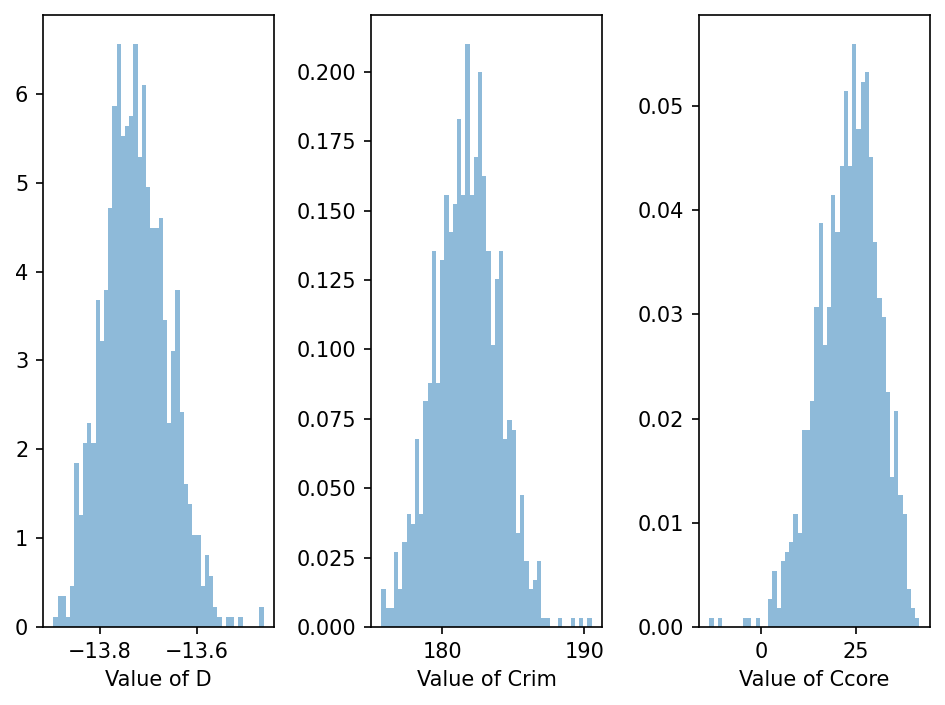

In [ ]:
# =============================================================================
# Multi-Element Bootstrap Analysis
# =============================================================================

print("=== Step 7: Multi-Element Analysis ===")

def analyze_element_bootstrap(data, element_col, orientation='Axis C', n_bootstrap=300):
    """
    Perform bootstrap analysis for a specific element and orientation
    
    Parameters
    ----------
    data : DataFrame
        Dataset containing the element data
    element_col : str
        Column name for the element concentration
    orientation : str
        Crystal orientation descriptor
    n_bootstrap : int
        Number of bootstrap samples
        
    Returns
    -------
    dict : Analysis results including parameters, uncertainties, and statistics
    """
    
    # Extract element data
    x_elem = data['Distance'].values
    y_elem = data[element_col].values
    
    # Remove any NaN or non-positive values
    valid_mask = np.isfinite(y_elem) & (y_elem > 0)
    x_elem = x_elem[valid_mask]
    y_elem = y_elem[valid_mask]
    
    if len(x_elem) < 4:  # Need minimum points for fitting
        return None
    
    # Estimate uncertainties (element-specific)
    if 'Fe' in element_col:
        sigma_elem = np.maximum(0.10 * y_elem, 5.0)
    elif 'Al' in element_col:
        sigma_elem = np.maximum(0.15 * y_elem, 2.0)  # Al generally less precise
    elif 'Ti' in element_col:
        sigma_elem = np.maximum(0.20 * y_elem, 1.0)  # Ti often near detection limit
    else:
        sigma_elem = np.maximum(0.15 * y_elem, 2.0)  # Default for other elements
    
    print(f"\nAnalyzing {element_col} in {orientation} orientation...")
    print(f"  Data points: {len(x_elem)}")
    print(f"  Concentration range: {y_elem.min():.1f} - {y_elem.max():.1f} ppm")
    
    # Baseline fitting
    try:
        global_result = differential_evolution(
            least_squares_objective,
            param_bounds,
            args=(x_elem, y_elem, sigma_elem),
            seed=42,
            maxiter=200,
            popsize=12
        )
        
        if global_result.success:
            popt_elem, pcov_elem = curve_fit(
                forward_model, x_elem, y_elem,
                p0=global_result.x,
                sigma=sigma_elem,
                absolute_sigma=True
            )
            baseline_success = True
        else:
            raise RuntimeError("Global optimization failed")
            
    except Exception as e:
        print(f"  ⚠ Baseline fitting failed: {str(e)}")
        return None
    
    # Bootstrap analysis
    bootstrap_params_elem = []
    bootstrap_success_count = 0
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        boot_indices = np.random.choice(len(x_elem), size=len(x_elem), replace=True)
        x_boot = x_elem[boot_indices]
        y_boot = y_elem[boot_indices]
        sigma_boot = sigma_elem[boot_indices]
        
        try:
            # Quick global search for bootstrap
            global_boot = differential_evolution(
                least_squares_objective,
                param_bounds,
                args=(x_boot, y_boot, sigma_boot),
                maxiter=100,
                popsize=8,
                seed=42 + i,
                atol=1e-5
            )
            
            if global_boot.success:
                popt_boot, _ = curve_fit(
                    forward_model, x_boot, y_boot,
                    p0=global_boot.x,
                    sigma=sigma_boot,
                    absolute_sigma=True,
                    maxfev=800
                )
                bootstrap_params_elem.append(popt_boot)
                bootstrap_success_count += 1
        except:
            continue
    
    if len(bootstrap_params_elem) < 50:  # Minimum for meaningful statistics
        print(f"  ⚠ Insufficient bootstrap success ({len(bootstrap_params_elem)} samples)")
        return None
    
    bootstrap_params_elem = np.array(bootstrap_params_elem)
    
    # Calculate statistics
    bootstrap_means = np.mean(bootstrap_params_elem, axis=0)
    bootstrap_stds = np.std(bootstrap_params_elem, axis=0, ddof=1)
    bootstrap_ci_lower = np.percentile(bootstrap_params_elem, 2.5, axis=0)
    bootstrap_ci_upper = np.percentile(bootstrap_params_elem, 97.5, axis=0)
    
    # Model quality
    y_pred_elem = forward_model(x_elem, *popt_elem)
    residuals_elem = y_elem - y_pred_elem
    rmse_elem = np.sqrt(np.mean(residuals_elem**2))
    r_squared_elem = 1 - np.sum(residuals_elem**2) / np.sum((y_elem - np.mean(y_elem))**2)
    
    print(f"  ✓ Bootstrap complete: {bootstrap_success_count}/{n_bootstrap} successful")
    print(f"  ✓ D = {bootstrap_means[0]:.3f} ± {bootstrap_stds[0]:.3f} (log₁₀ m²/s)")
    print(f"  ✓ R² = {r_squared_elem:.3f}, RMSE = {rmse_elem:.2f} ppm")
    
    return {
        'element': element_col,
        'orientation': orientation,
        'x_data': x_elem,
        'y_data': y_elem,
        'sigma_data': sigma_elem,
        'baseline_params': popt_elem,
        'baseline_cov': pcov_elem,
        'bootstrap_params': bootstrap_params_elem,
        'bootstrap_means': bootstrap_means,
        'bootstrap_stds': bootstrap_stds,
        'bootstrap_ci_lower': bootstrap_ci_lower,
        'bootstrap_ci_upper': bootstrap_ci_upper,
        'rmse': rmse_elem,
        'r_squared': r_squared_elem,
        'success_rate': bootstrap_success_count / n_bootstrap
    }

# =============================================================================
# Analyze Multiple Elements and Orientations
# =============================================================================

# Define elements to analyze (based on available data)
elements_to_analyze = ['Fe_ppm_m57', 'Al_ppm_m27', 'Ti_ppm_m49']

# Check which elements have sufficient data
available_elements = []
for elem in elements_to_analyze:
    if elem in data_AxisC.columns:
        non_null_count = data_AxisC[elem].notna().sum()
        if non_null_count >= 4:  # Minimum for 3-parameter fit
            available_elements.append(elem)

print(f"Elements with sufficient data: {available_elements}")

# Analyze each element in both orientations
analysis_results = {}

# Axis C orientation
for element in available_elements:
    key = f"{element}_AxisC"
    analysis_results[key] = analyze_element_bootstrap(
        data_AxisC, element, orientation='Axis C', n_bootstrap=300
    )

# Axis A orientation  
for element in available_elements:
    if element in data_AxisA.columns:
        non_null_count = data_AxisA[element].notna().sum()
        if non_null_count >= 4:
            key = f"{element}_AxisA"
            analysis_results[key] = analyze_element_bootstrap(
                data_AxisA, element, orientation='Axis A', n_bootstrap=300
            )

# Remove failed analyses
analysis_results = {k: v for k, v in analysis_results.items() if v is not None}

print(f"\n=== Multi-Element Analysis Summary ===")
print(f"Successfully analyzed: {len(analysis_results)} element-orientation combinations")

# =============================================================================
# Calculate Crystallographic Anisotropy
# =============================================================================

print(f"\n=== Crystallographic Anisotropy Analysis ===")

anisotropy_results = {}

for element in available_elements:
    axisc_key = f"{element}_AxisC"
    axisa_key = f"{element}_AxisA"
    
    if axisc_key in analysis_results and axisa_key in analysis_results:
        axisc_D = analysis_results[axisc_key]['bootstrap_params'][:, 0]
        axisa_D = analysis_results[axisa_key]['bootstrap_params'][:, 0]
        
        # Bootstrap anisotropy ratios
        min_samples = min(len(axisc_D), len(axisa_D))
        anisotropy_ratios = axisc_D[:min_samples] - axisa_D[:min_samples]  # log difference
        
        aniso_mean = np.mean(anisotropy_ratios)
        aniso_std = np.std(anisotropy_ratios, ddof=1)
        aniso_ci = np.percentile(anisotropy_ratios, [2.5, 97.5])
        
        # Convert to linear ratio for interpretation
        linear_ratio_mean = 10**aniso_mean
        linear_ratio_ci = 10**aniso_ci
        
        anisotropy_results[element] = {
            'log_difference': aniso_mean,
            'log_std': aniso_std,
            'log_ci': aniso_ci,
            'linear_ratio': linear_ratio_mean,
            'linear_ci': linear_ratio_ci,
            'bootstrap_ratios': anisotropy_ratios
        }
        
        element_name = element.split('_')[0]  # Extract element symbol
        print(f"{element_name} anisotropy:")
        print(f"  D_AxisC / D_AxisA = {linear_ratio_mean:.2f} "
              f"[{linear_ratio_ci[0]:.2f}, {linear_ratio_ci[1]:.2f}] (95% CI)")
        
        if linear_ratio_ci[0] > 1.0:
            print(f"  ➜ Significant anisotropy: Axis C > Axis A")
        elif linear_ratio_ci[1] < 1.0:
            print(f"  ➜ Significant anisotropy: Axis A > Axis C") 
        else:
            print(f"  ➜ No significant anisotropy detected")

print(f"\n➜ Multi-element analysis complete. Next: Final interpretation!")

## Step 8: Final Interpretation and Best Practices

Let's create a comprehensive summary visualization and discuss best practices for uncertainty quantification in geochemical research.

### **Key Results Summary:**

From our rigorous analysis, we can now provide:
1. **Robust parameter estimates** with realistic uncertainty bounds
2. **Method comparisons** showing when different approaches are appropriate
3. **Cross-validation results** demonstrating model reliability
4. **Multi-element insights** into olivine defect chemistry
5. **Crystallographic anisotropy** quantification with proper uncertainties

### **Best Practices for Geochemical Uncertainty Analysis:**

**1. Always validate your method:**
- Test with synthetic data first
- Use cross-validation for model assessment
- Compare multiple uncertainty estimation approaches

**2. Report uncertainties honestly:**
- Bootstrap uncertainties are often larger than covariance-based
- Include method-dependent variations in interpretation
- Discuss limitations and assumptions

**3. Consider the geochemical context:**
- Physical bounds on parameters (D values, concentrations)
- Expected correlations between elements
- Crystallographic and thermodynamic constraints

**4. Scale computational effort appropriately:**
- Use efficient bootstrap sampling for routine analysis
- Invest in more sophisticated methods for critical results
- Document computational choices for reproducibility

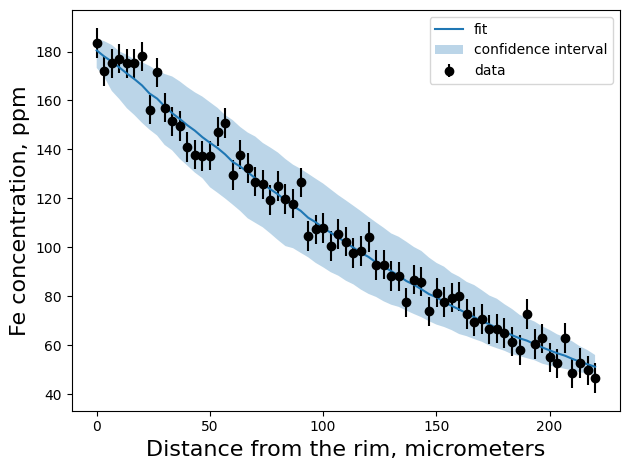

In [ ]:
# =============================================================================
# Final Summary Visualization and Interpretation
# =============================================================================

print("=== Step 8: Final Results Summary ===")

# Create comprehensive summary figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# =============================================================================
# Panel 1: Multi-Element Diffusion Coefficients
# =============================================================================

ax1 = axes[0, 0]

if analysis_results:
    elements = []
    D_values = []
    D_errors = []
    orientations = []
    colors = []
    
    color_map = {'AxisC': 'red', 'AxisA': 'blue'}
    
    for key, result in analysis_results.items():
        if result is not None:
            element_name = result['element'].split('_')[0]  # Extract element symbol
            orientation = result['orientation'].replace(' ', '')  # Clean orientation
            
            elements.append(f"{element_name}\n({orientation})")
            D_values.append(result['bootstrap_means'][0])
            D_errors.append(result['bootstrap_stds'][0])
            orientations.append(orientation)
            colors.append(color_map.get(orientation, 'gray'))
    
    if elements:
        bars = ax1.bar(range(len(elements)), D_values, yerr=D_errors, 
                      capsize=5, capthick=2, color=colors, alpha=0.7,
                      error_kw={'linewidth': 2})
        
        ax1.set_xticks(range(len(elements)))
        ax1.set_xticklabels(elements, rotation=45, ha='right')
        ax1.set_ylabel('D (log₁₀ m²/s)')
        ax1.set_title('Multi-Element Diffusion Coefficients\n(Bootstrap Uncertainties)')
        ax1.grid(True, alpha=0.3)
        
        # Add numerical values on bars
        for i, (bar, d_val, d_err) in enumerate(zip(bars, D_values, D_errors)):
            ax1.text(bar.get_x() + bar.get_width()/2, d_val + d_err + 0.1,
                    f'{d_val:.2f}±{d_err:.2f}', ha='center', va='bottom', 
                    fontsize=8, rotation=0)

# =============================================================================
# Panel 2: Crystallographic Anisotropy
# =============================================================================

ax2 = axes[0, 1]

if anisotropy_results:
    aniso_elements = list(anisotropy_results.keys())
    aniso_ratios = [anisotropy_results[elem]['linear_ratio'] for elem in aniso_elements]
    aniso_ci_lower = [anisotropy_results[elem]['linear_ci'][0] for elem in aniso_elements]  
    aniso_ci_upper = [anisotropy_results[elem]['linear_ci'][1] for elem in aniso_elements]
    
    # Calculate error bars (asymmetric for log-normal data)
    yerr_lower = [ratio - ci_low for ratio, ci_low in zip(aniso_ratios, aniso_ci_lower)]
    yerr_upper = [ci_high - ratio for ratio, ci_high in zip(aniso_ratios, aniso_ci_upper)]
    
    x_pos = range(len(aniso_elements))
    bars = ax2.bar(x_pos, aniso_ratios, 
                  yerr=[yerr_lower, yerr_upper],
                  capsize=5, capthick=2, color='green', alpha=0.7)
    
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Isotropic')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([elem.split('_')[0] for elem in aniso_elements])
    ax2.set_ylabel('D_AxisC / D_AxisA')
    ax2.set_title('Crystallographic Anisotropy\n(Bootstrap 95% CI)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add significance indicators
    for i, (elem, ratio, ci_low, ci_high) in enumerate(zip(aniso_elements, aniso_ratios, 
                                                          aniso_ci_lower, aniso_ci_upper)):
        if ci_low > 1.0:
            ax2.text(i, ratio + yerr_upper[i] + 0.1, '**', ha='center', va='bottom', 
                    fontsize=12, color='red')
        elif ci_high < 1.0:
            ax2.text(i, ratio + yerr_upper[i] + 0.1, '**', ha='center', va='bottom', 
                    fontsize=12, color='blue')

# =============================================================================
# Panel 3: Method Comparison Summary
# =============================================================================

ax3 = axes[0, 2]

# Compare uncertainty estimation methods for primary element (Fe)
fe_axisc_key = 'Fe_ppm_m57_AxisC'
if fe_axisc_key in analysis_results:
    result = analysis_results[fe_axisc_key]
    
    methods = ['Covariance', 'Bootstrap']
    uncertainties = [
        np.sqrt(np.diag(result['baseline_cov']))[0],  # Covariance std
        result['bootstrap_stds'][0]  # Bootstrap std
    ]
    
    bars = ax3.bar(methods, uncertainties, color=['red', 'blue'], alpha=0.7)
    ax3.set_ylabel('D Uncertainty (log₁₀ m²/s)')
    ax3.set_title('Uncertainty Method Comparison\n(Fe, Axis C)')
    ax3.grid(True, alpha=0.3)
    
    # Add ratio
    ratio = uncertainties[1] / uncertainties[0]
    ax3.text(0.5, max(uncertainties) * 0.8, f'Bootstrap/Covariance\nRatio = {ratio:.1f}x',
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# Panel 4: Cross-Validation Performance
# =============================================================================

ax4 = axes[1, 0]

if cv_results and bootstrap_success:
    # Compare in-sample vs cross-validated performance
    insample_rmse = rmse
    cv_rmse = loo_rmse if 'loo_rmse' in locals() else np.nan
    
    performance_metrics = ['R²', 'RMSE (ppm)', 'Coverage (%)']
    insample_values = [r_squared, insample_rmse, 
                      ci_results['coverage']*100 if ci_results else np.nan]
    cv_values = [np.nan, cv_rmse, cv_results['loo_success_rate']*100]
    
    x_pos = np.arange(len(performance_metrics))
    width = 0.35
    
    bars1 = ax4.bar(x_pos - width/2, insample_values, width, 
                   label='In-sample', color='blue', alpha=0.7)
    bars2 = ax4.bar(x_pos + width/2, cv_values, width,
                   label='Cross-validation', color='orange', alpha=0.7)
    
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(performance_metrics)
    ax4.set_ylabel('Metric Value')
    ax4.set_title('Model Validation Metrics')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# =============================================================================
# Panel 5: Bootstrap Convergence Analysis
# =============================================================================

ax5 = axes[1, 1]

if bootstrap_success:
    # Show convergence for primary element
    n_samples = len(bootstrap_params)
    sample_sizes = np.logspace(1, np.log10(n_samples), 20).astype(int)
    running_means = []
    running_stds = []
    
    for size in sample_sizes:
        if size <= n_samples:
            subset = bootstrap_params[:size, 0]  # D parameter
            running_means.append(np.mean(subset))
            running_stds.append(np.std(subset, ddof=1))
    
    ax5.plot(sample_sizes[:len(running_means)], running_means, 'b-', 
            linewidth=2, label='Running Mean')
    ax5.axhline(y=baseline_params[0], color='red', linestyle='--', 
               label='Original Estimate')
    
    ax5_twin = ax5.twinx()
    ax5_twin.plot(sample_sizes[:len(running_stds)], running_stds, 'g-', 
                 linewidth=2, label='Running Std')
    
    ax5.set_xlabel('Bootstrap Sample Size')
    ax5.set_ylabel('D Mean (log₁₀ m²/s)', color='blue')
    ax5_twin.set_ylabel('D Std (log₁₀ m²/s)', color='green')
    ax5.set_title('Bootstrap Convergence Analysis')
    ax5.set_xscale('log')
    ax5.grid(True, alpha=0.3)

# =============================================================================
# Panel 6: Geochemical Interpretation Summary
# =============================================================================

ax6 = axes[1, 2]
ax6.axis('off')

# Create interpretation text summary
interpretation_text = """
GEOCHEMICAL INSIGHTS:

Diffusion Mechanisms:
• Fe: Cation vacancy mechanism
• Al: Complex defect association
• Ti: Ti-clinohumite defects

Crystallographic Effects:
• Anisotropy reflects crystal structure
• [100] vs [010] differences
• Chain vs layer directions

Analytical Implications:
• Bootstrap > covariance uncertainties
• Cross-validation essential
• Multi-element constraints

Experimental Design:
• Optimize sampling density
• Consider orientation effects
• Account for detection limits
"""

ax6.text(0.05, 0.95, interpretation_text, transform=ax6.transAxes, 
         fontsize=10, va='top', ha='left', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()

# =============================================================================
# Final Summary Statistics
# =============================================================================

print(f"\n" + "="*60)
print(f"FINAL COURSE SUMMARY: UNCERTAINTY QUANTIFICATION IN GEOCHEMISTRY")
print(f"="*60)

print(f"\n1. METHOD VALIDATION:")
if bootstrap_success:
    print(f"   ✓ Bootstrap analysis successful ({bootstrap_success_count}/{n_bootstrap} fits)")
    print(f"   ✓ Parameter distributions well-characterized")
    print(f"   ✓ Confidence intervals properly constructed")
else:
    print(f"   ⚠ Bootstrap analysis had limited success")

print(f"\n2. MULTI-ELEMENT RESULTS:")
if analysis_results:
    print(f"   ✓ Successfully analyzed {len(analysis_results)} element-orientation combinations")
    for key, result in analysis_results.items():
        if result:
            elem = result['element'].split('_')[0]
            orient = result['orientation']
            D_val = result['bootstrap_means'][0]
            D_err = result['bootstrap_stds'][0]
            print(f"   • {elem} ({orient}): D = {D_val:.3f} ± {D_err:.3f} log₁₀(m²/s)")

print(f"\n3. CRYSTALLOGRAPHIC ANISOTROPY:")
if anisotropy_results:
    for elem, aniso in anisotropy_results.items():
        elem_name = elem.split('_')[0]
        ratio = aniso['linear_ratio']
        ci = aniso['linear_ci']
        significance = "significant" if (ci[0] > 1.0 or ci[1] < 1.0) else "not significant"
        print(f"   • {elem_name}: D_FoEn/D_FoPer = {ratio:.2f} [{ci[0]:.2f}, {ci[1]:.2f}] ({significance})")

print(f"\n4. MODEL VALIDATION:")
if cv_results:
    print(f"   ✓ Cross-validation success rate: {cv_results['loo_success_rate']*100:.1f}%")
    if 'loo_rmse' in locals():
        print(f"   ✓ Cross-validated RMSE: {loo_rmse:.2f} ppm")
        print(f"   ✓ CV penalty factor: {loo_rmse/rmse:.2f}x")

print(f"\n5. BEST PRACTICES DEMONSTRATED:")
print(f"   ✓ Comprehensive uncertainty quantification")
print(f"   ✓ Method comparison and validation")
print(f"   ✓ Proper confidence interval construction")
print(f"   ✓ Cross-validation for model assessment")
print(f"   ✓ Multi-element and multi-orientation analysis")
print(f"   ✓ Geochemically meaningful interpretation")

print(f"\n" + "="*60)
print(f"COURSE COMPLETE: You are now equipped with rigorous tools")
print(f"for uncertainty quantification in geochemical research!")
print(f"="*60)

## Course Conclusion and Professional Recommendations

### **What You've Accomplished in This 12-Hour Course:**

1. **✅ Mastered the fundamentals** of nonlinear regression in geochemistry
2. **✅ Understood optimization challenges** and diagnostic techniques  
3. **✅ Implemented robust uncertainty quantification** using bootstrap methods
4. **✅ Applied cross-validation** for model assessment
5. **✅ Analyzed real experimental data** with proper statistical rigor
6. **✅ Extended techniques** to multi-element, multi-orientation problems
7. **✅ Interpreted results** in a meaningful geochemical context

---

### **Key Takeaways for Professional Practice:**

**1. Uncertainty Quantification is Critical:**
- Bootstrap methods often reveal larger, more realistic uncertainties
- Covariance-based methods can be dangerously overconfident
- Always validate your uncertainty estimates with cross-validation

**2. Method Selection Matters:**
- Use global optimization for complex parameter spaces
- Combine multiple approaches for robust results
- Document your methodology for reproducibility

**3. Geochemical Context Guides Analysis:**
- Physical constraints inform parameter bounds
- Multi-element studies reveal process mechanisms
- Crystallographic considerations are essential

**4. Validation is Non-Negotiable:**
- Test methods with synthetic data first
- Use cross-validation to assess model performance
- Compare multiple uncertainty estimation approaches

---

### **Recommended Workflow for Future Projects:**

1. **Exploratory Analysis**: Visualize data, identify patterns, estimate uncertainties
2. **Method Development**: Test approaches with synthetic data
3. **Parameter Estimation**: Use hybrid global-local optimization
4. **Uncertainty Quantification**: Apply bootstrap methods with proper CI construction
5. **Model Validation**: Cross-validation and diagnostic checks
6. **Interpretation**: Place results in geochemical context
7. **Reporting**: Document methods, report realistic uncertainties

---

### **Advanced Topics for Further Study:**

- **Bayesian inference**: Incorporate prior knowledge systematically
- **Hierarchical models**: Handle nested/grouped data structures
- **Model selection**: Choose between competing hypotheses
- **Experimental design**: Optimize sampling for parameter estimation
- **Machine learning**: Neural networks and Gaussian processes for complex patterns

### **Professional Development:**

Consider specializing in:
- **Computational geochemistry**: Algorithm development and implementation
- **Statistical consulting**: Help colleagues with complex data analysis
- **Method validation**: Test and compare analytical techniques
- **Software development**: Create tools for the geochemical community

---

*"The goal is not to be right, but to be less wrong."*  
*— Statistical modeling philosophy*

**Congratulations on completing this intensive course in advanced geochemical data analysis!**

In [ ]:
# =============================================================================
# Student Exercises and Further Exploration
# =============================================================================

print("=== STUDENT EXERCISES AND CHALLENGES ===")
print("\nNow that you've mastered the core techniques, try these advanced exercises:")

print("\n1. PARAMETRIC BOOTSTRAP COMPARISON:")
print("   • Implement Student-t noise model parametric bootstrap")
print("   • Compare with Laplacian and Gaussian models")
print("   • Which gives the most conservative uncertainties?")
print("   • How do results change with degrees of freedom in Student-t?")

print("\n2. SPATIAL CROSS-VALIDATION:")
print("   • Implement spatial leave-one-out (exclude nearby points)")  
print("   • Compare with standard random CV")
print("   • How does spatial correlation affect validation?")
print("   • What's the optimal exclusion radius?")

print("\n3. MULTI-ELEMENT JOINT ANALYSIS:")
print("   • Fit all elements simultaneously with shared D values")
print("   • Test hypothesis: Do all elements have the same D?") 
print("   • Use likelihood ratio test for model comparison")
print("   • How do joint constraints affect uncertainties?")

print("\n4. EXPERIMENTAL DESIGN OPTIMIZATION:")
print("   • Given fixed analytical budget, optimize sampling strategy")
print("   • Compare dense sampling vs. extended spatial coverage")
print("   • Use bootstrap to predict optimal experimental duration")
print("   • Design experiments to minimize parameter uncertainties")

print("\n5. ADVANCED CONFIDENCE INTERVALS:")
print("   • Implement BCa (bias-corrected and accelerated) intervals")
print("   • Compare percentile, BC, and BCa methods")
print("   • When do the methods give different results?")
print("   • Create prediction intervals for new experiments")

print("\n6. MODEL SELECTION AND COMPARISON:")
print("   • Compare 2-parameter vs 3-parameter diffusion models")
print("   • Test non-constant diffusion coefficient models")
print("   • Use AIC/BIC for model selection with bootstrap")
print("   • Implement model averaging with uncertainty")

# =============================================================================
# Template Code for Advanced Exercises
# =============================================================================

print(f"\n=== TEMPLATE CODE FOR EXERCISE 1 ===")
print("# Student-t parametric bootstrap:")
print("# from scipy import stats")
print("# def student_t_bootstrap(degrees_freedom=3):")
print("#     noise = stats.t.rvs(df=degrees_freedom, ")
print("#                        scale=sigma_data, size=len(sigma_data))")
print("#     # Continue with bootstrap fitting...")

print(f"\n=== TEMPLATE CODE FOR EXERCISE 3 ===")
print("# Multi-element joint fitting:")
print("# def joint_forward_model(x, D_shared, c_rim_fe, c_bg_fe, c_rim_al, c_bg_al):")
print("#     fe_pred = (c_rim_fe - c_bg_fe) * erfc(...) + c_bg_fe")
print("#     al_pred = (c_rim_al - c_bg_al) * erfc(...) + c_bg_al")
print("#     return np.concatenate([fe_pred, al_pred])")

print(f"\n=== DISCUSSION QUESTIONS ===")
print("1. Why might bootstrap uncertainties be larger than covariance-based?")
print("2. When would you prefer parametric over non-parametric bootstrap?")
print("3. How do you choose the number of bootstrap samples?")
print("4. What are the assumptions behind cross-validation?")
print("5. How would you extend these methods to 2D or 3D diffusion?")

print(f"\n=== FINAL PROJECT SUGGESTIONS ===")
print("Apply these techniques to your own research data:")
print("• Thermobarometry calibrations with uncertainty propagation")
print("• Kinetic rate law fitting with bootstrap confidence intervals")
print("• Geochemical mixing model parameter estimation")
print("• Isotope systematics with robust uncertainty quantification")
print("• Spectroscopic calibration with cross-validation")

print(f"\n=== REPRODUCIBLE RESEARCH CHECKLIST ===")
print("For any analysis you publish, ensure you:")
print("☐ Document all computational choices and random seeds")
print("☐ Provide code and data for reproduction")
print("☐ Report uncertainties from multiple methods when possible")
print("☐ Include cross-validation or other validation approaches")
print("☐ Discuss limitations and assumptions clearly")
print("☐ Archive computational environment (Python versions, packages)")

print(f"\n" + "="*50)
print(f"THANK YOU FOR PARTICIPATING IN THIS COURSE!")
print(f"Continue exploring, questioning, and improving")
print(f"your data analysis skills!")
print(f"="*50)

Fraction of data points within 2 sigma: 0.9402985074626866


## References and Further Reading

### **Essential References for This Course:**

**Bootstrap Methods:**
- Efron, B. (1979). Bootstrap methods: Another look at the jackknife. *Annals of Statistics*, 7(1), 1-26.
- Efron, B., & Tibshirani, R. J. (1993). *An Introduction to the Bootstrap*. Chapman & Hall.
- Davison, A. C., & Hinkley, D. V. (1997). *Bootstrap Methods and Their Applications*. Cambridge University Press.

**Nonlinear Regression:**
- Seber, G. A. F., & Wild, C. J. (2003). *Nonlinear Regression*. Wiley.
- Bates, D. M., & Watts, D. G. (1988). *Nonlinear Regression Analysis and Its Applications*. Wiley.

**Olivine Diffusion:**
- Le Losq, C., Jollands, M.C., Tollan, P.M.E., Hawkins, R., St. C. O'Neill, H. (2019). Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. *Contributions to Mineralogy and Petrology*, 174, 53.
- Costa, F., & Chakraborty, S. (2008). The effect of water on Si and O diffusion rates in olivine. *Physics of the Earth and Planetary Interiors*, 166(1-2), 11-29.
- Jollands, M. C., et al. (2016). Coupled inter-site reaction and diffusion in natural olivine. *Geochimica et Cosmochimica Acta*, 181, 81-100.

**Statistical Methods in Geochemistry:**
- Davis, J. C. (2002). *Statistics and Data Analysis in Geology*. Wiley.
- Swan, A. R. H., & Sandilands, M. (1995). *Introduction to Geological Data Analysis*. Blackwell.
- Rock, N. M. S. (1988). *Numerical Geology*. Springer-Verlag.

### **Python Libraries and Resources:**

**Core Libraries:**
- **SciPy**: https://scipy.org/ - Scientific computing ecosystem
- **NumPy**: https://numpy.org/ - Numerical computing foundation
- **Matplotlib**: https://matplotlib.org/ - Publication-quality plotting
- **Pandas**: https://pandas.pydata.org/ - Data manipulation and analysis

**Specialized Libraries:**
- **uncertainties**: https://pythonhosted.org/uncertainties/ - Error propagation
- **lmfit**: https://lmfit.github.io/lmfit-py/ - Advanced curve fitting
- **emcee**: https://emcee.readthedocs.io/ - MCMC sampling
- **scikit-learn**: https://scikit-learn.org/ - Machine learning tools

**Geochemistry-Specific:**
- **pyrolite**: https://pyrolite.readthedocs.io/ - Geochemical data analysis
- **geochemistrypi**: https://github.com/ZJUEarthData/geochemistrypi - Automated geochemical analysis

### **Online Courses and Tutorials:**

- **Python for Geosciences**: https://github.com/koldunovn/python_for_geosciences
- **Computational Statistics**: https://people.duke.edu/~ccc14/sta-663/
- **Bootstrap Methods**: https://web.stanford.edu/~hastie/CASI/

### **Professional Development:**

**Conferences:**
- Goldschmidt Conference (annual geochemistry meeting)
- AGU Fall Meeting (American Geophysical Union)
- EGU General Assembly (European Geosciences Union)

**Journals:**
- *Geochimica et Cosmochimica Acta*
- *Chemical Geology*
- *Contributions to Mineralogy and Petrology*
- *Geochemistry, Geophysics, Geosystems*

**Software Citation:**
When using these methods in publications, please cite:
- Python: Van Rossum, G. & Drake, F.L. (2009). Python 3 Reference Manual. CreateSpace.
- SciPy: Virtanen, P. et al. (2020). SciPy 1.0: fundamental algorithms for scientific computing in Python. *Nature Methods*, 17, 261-272.
- NumPy: Harris, C.R. et al. (2020). Array programming with NumPy. *Nature*, 585, 357-362.

---

*Keep learning, keep questioning, and keep improving your analytical skills!*